# SSMachine Tutorial

In [1]:
import glob
import numpy as np
import pandas as pd
import lightkurve as lk
import psfmachine as pm
from astropy.io import fits
from scipy import sparse

import matplotlib.pyplot as plt

import warnings
from astropy.utils.exceptions import AstropyUserWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=sparse.SparseEfficiencyWarning)
warnings.filterwarnings("ignore", category=AstropyUserWarning)

## K2 Super Stamps Tutorial

This notebook shows how to use `PSFMachine` and the submodule `SSMachine` to work with K2 Super Stamps images produced by 
[Cody et al. 2018](https://archive.stsci.edu/prepds/k2superstamp/).
[`PSFMachine`](https://github.com/SSDataLab/psfmachine) uses Gaia as source catalog and fits a PSF model of the "scene" (all sources) at once.
The method is described with details in [Hedges et al. 2021](https://ui.adsabs.harvard.edu/abs/2021AJ....162..107H/abstract).

K2 Super stamps are stored in single FITS files per cadence that are parsed by `SSMAchine` to then use the `Mahine` class.
This object class has several handy methods that allow us to get a scene PSF model and fit it to get PSF photometry, as well as aperture photometry
with aperture masks that follows the PSF profile. `Machine` also provides several plotting functionalities to create diagnostic figures and for
bookkeeping.
For more details on how to use `PSFMachine`, please take a look at this [notebook tutorial](https://github.com/SSDataLab/psfmachine/blob/master/tutorials/how_to_use_TPFMachine.ipynb) 
and its [documentation](https://ssdatalab.github.io/psfmachine/).

In this example we'll work with M67.

## M67 open clusters

First, make sure you have the data stored locally. [Here](https://archive.stsci.edu/prepds/k2superstamp/)
are instructions on how to download it.

In [2]:
# modify this to refelt the directory path on your system
data_path = "/Users/jorgemarpa/Work/BAERI/ADAP/data/k2/superstamps/m67"
m67_fnames = np.sort(glob.glob(
    f"{data_path}/hlsp_k2superstamp_k2_photometer_c5-m67-*_kepler_v1_image.fits"))

Each FITS file contains a single cadence (epoch), here's and example of the file content

In [3]:
m67_hdu = fits.open(m67_fnames[1])
m67_hdu.info()

Filename: /Users/jorgemarpa/Work/BAERI/ADAP/data/k2/superstamps/m67/hlsp_k2superstamp_k2_photometer_c5-m67-bjd2457139.6315_kepler_v1_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     176   (400, 400)   float32   


## Create a `Machine` object

The `SSMachine` module has the static method `SSMachine.from_file` that allows us to load a stack of FITS files.
We just have to provide the path to each FITS file as a list and other parameters such as:

* `magnitude_limit`: the limiting magnitude to query Gaia catalog
* `dr`: which is the Gaia Data Release, if 3 then uses EDR3
* Other `**kwargs` that define model parameters in `Machine`, see [here](https://ssdatalab.github.io/psfmachine/machine/#psfmachine.machine.Machine.__init__) for details.

Internally, `Machine` queries Gaia catalogs to fins sources on and nearby pixels.
In this case we limit the Gaia EDR3 query to sources up to 18th magnitude. Also, we'll only load the first 500 cadences for this example.
If we `print` the object will return a brief description of the available data

In [4]:
m67 = pm.SSMachine.from_file(m67_fnames[:500].tolist(), magnitude_limit=18, dr=3)
m67

Creating delta arrays: 100%|██████████| 1019/1019 [00:01<00:00, 576.19it/s]


FFIMachine (N sources, N times, N pixels): (1019, 500, 156578)

In [5]:
# the `m67.meta` attribuite has general information of the data
m67.meta

{'TELESCOP': 'Kepler',
 'INSTRUME': 'Kepler Photometer',
 'MISSION': 'K2',
 'OBSMODE': 'long cadence',
 'OBJECT': 'M67',
 'RADESYS': 'ICRS',
 'EQUINOX': 2000.0,
 'BACKAPP': True,
 'EXTENSION': None,
 'QUARTER': 5,
 'DCT_TYPE': 'SuperStamp'}

Let's see how **M67** looks like as seen with Kepler eyes! The red circles are Gaia EDR3 sources.

There are some nasty crosstalk artifacts

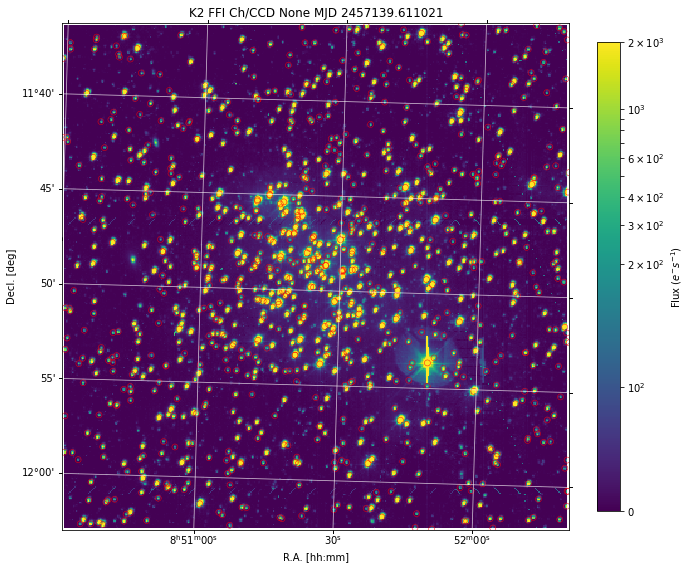

In [6]:
m67.plot_image(sources=True);

## mean-PSF

Now let's build a PSF model (aka shape model). For this, `SSMachine` (inherited from `Machine`) has the `.build_shape_model()` method.
Here, `.build_shape_model()` accepts the parameter `frame_index` that can be an integer (cadence number) or `mean` to use the time-averaged flux. 
If `cadenceno` is an int, the it uses the flux of that particular cadence to fit the PRF, if is `mean` the computes a PSF model of the mean flux.

The figure shows the PSF model in both Cartesian (left) and Polar (right) coordinates, and the data (top) and model (bottom).

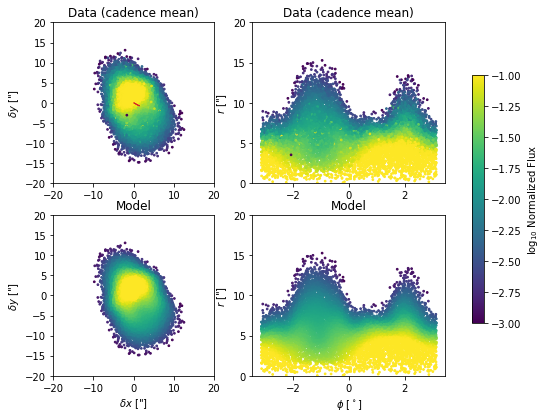

In [13]:
m67.build_shape_model(frame_index='mean', plot=True);

## Time Model

`Machine` uses a **time model** to fit the drift in position (velocity aberration) of all sources (the scene).
This is a nice solution when the drift is smooth, the case of Kepler, but for K2 the dominant factor is the jitter we saw above.
Still, let's try to fit this "time model" and compare results.


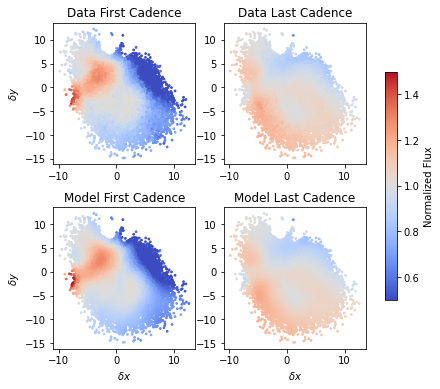

Fitting 1019 Sources (w. VA): 100%|██████████| 500/500 [01:03<00:00,  7.92it/s]


In [15]:
# make sure we use the time polynomial model and 200 cadences per time bin
m67.time_corrector = "polynomial"
m67.n_time_points = 200
m67.build_time_model(plot=True, downsample=False);
plt.show()

# fit model and get the photometry
m67.fit_model(fit_va=True)

# let's save the photometry in different vairables so we can try multiple time models
m67.ws_va_time = m67.ws_va
m67.werrs_va_time = m67.werrs_va

We can use a better corrector for K2. If we know the change in position ($\delta x$ and $\delta y$) of sources centroids, we can correct the position of the PRF better than the time polynomial used above. Some super stamps (as well as TPFs) come with these values, aka `pos_corr`, for each axis. We can also use source centroids computed bi `Machine`, which should follow the `pos_corrs`. Let see how they look like.

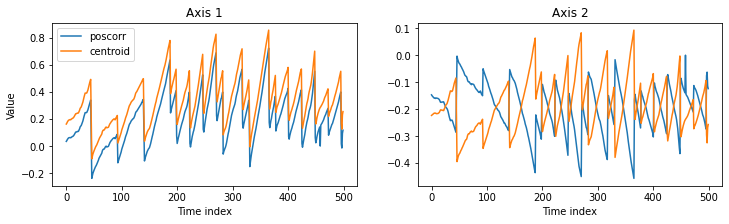

In [32]:
fig, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(m67.pos_corr1[0], label="poscorr")
# centroids are in world coordinates, while poscorrs are in pixels.
ax[0].plot(m67.ra_centroid.to("arcsec").value/4, label="centroid")
ax[0].set_title("Axis 1")
ax[0].set_xlabel("Time index")
ax[0].set_ylabel("Value")
ax[0].legend()
ax[1].set_title("Axis 2")
ax[1].plot(m67.pos_corr2[0], label="poscorr")
ax[1].plot(m67.dec_centroid.to("arcsec").value/4, label="centroid")
ax[1].set_xlabel("Time index")

plt.show()

Both `poscorrs` and `centroids` follow the same pattern as expected (`dec_centroid` are reflected due to the WCS conversion).
This means we can use either of them to build the time model.

Also, when building the time model, the basis are binned (or downsampled) to lower the dimensionality of the model. `Machine` does this automatically, but the bin size could be an important model parameter when dealing with K2 jitter.
Let's explore this:

In [34]:
# we tell machine to use poscorrs as basis
m67.time_corrector = "pos_corr"
# NO kernel smoothing of the poscorrs/centroids so we don't remove the jitter.
m67.poscorr_filter_size = 0
# n_time_points tells how many cadences are in one bin/downsample
m67.n_time_points = 200
# this is an internal Machine function, but we'll use it here to show how the 
# downsampling works 
(
    time_original,
    time_binned,
    flux_binned_raw,
    flux_binned,
    flux_err_binned,
    poscorr1_smooth,
    poscorr2_smooth,
    poscorr1_binned,
    poscorr2_binned,
) = m67._time_bin(npoints=m67.n_time_points, downsample=True)

using pos_corrs


The following plot shows the poscorrs (axis 1 column 1 and axis 2 in column 2) in the upper panel.
In black are the original values of the poscorrs, while in red are the smooth version of them. Because we set the
kernel size ti 0 both are equal. The green dots are the downsampled version of the poscorrs used to build the time model.

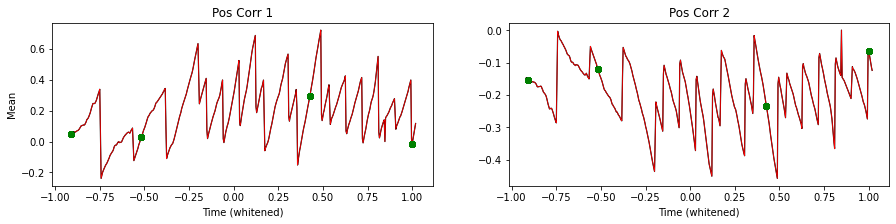

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15, 3))

ax[0].set_title("Pos Corr 1")
ax[0].plot(time_original, np.nanmedian(m67.pos_corr1, axis=0), c="k", lw=1.2, label="Median")
ax[0].plot(time_original, poscorr1_smooth, c="r", ls="-", lw=.8, label="Smooth")
ax[0].plot(time_binned, poscorr1_binned, c="g", marker="o", lw=0, ms=5, label="Knots")
ax[0].set_xlabel("Time (whitened)")
ax[0].set_ylabel("Mean")
# ax[0].legend(loc="upper left")

ax[1].set_title("Pos Corr 2")
ax[1].plot(time_original, np.nanmedian(m67.pos_corr2, axis=0), c="k", lw=1.2)
ax[1].plot(time_original, poscorr2_smooth, c="r", ls="-", lw=.8)
ax[1].plot(time_binned, poscorr2_binned, c="g", marker="o", lw=0, ms=5)
ax[1].set_xlabel("Time (whitened)")
plt.show()

By changing `m67.n_time_points = 200` to lower numbers (10), we get a finer resolution in time.

You can play with this parameter to create a higher resolution model in time, but that comes with larger model and longer computing times

using pos_corrs


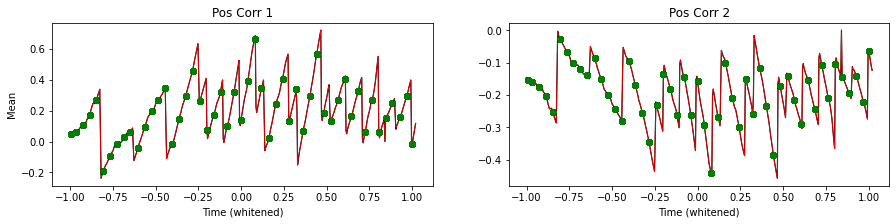

In [38]:
# we tell machine to use poscorrs as basis
m67.time_corrector = "pos_corr"
# NO kernel smoothing of the poscorrs/centroids so we don't remove the jitter.
m67.poscorr_filter_size = 0
# n_time_points tells how many cadences are in one bin/downsample
m67.n_time_points = 10
# this is an internal Machine function, but we'll use it here to show how the 
# downsampling works 
(
    time_original,
    time_binned,
    flux_binned_raw,
    flux_binned,
    flux_err_binned,
    poscorr1_smooth,
    poscorr2_smooth,
    poscorr1_binned,
    poscorr2_binned,
) = m67._time_bin(npoints=m67.n_time_points, downsample=True)
fig, ax = plt.subplots(1,2, figsize=(15, 3))

ax[0].set_title("Pos Corr 1")
ax[0].plot(time_original, np.nanmedian(m67.pos_corr1, axis=0), c="k", lw=1.2, label="Median")
ax[0].plot(time_original, poscorr1_smooth, c="r", ls="-", lw=.8, label="Smooth")
ax[0].plot(time_binned, poscorr1_binned, c="g", marker="o", lw=0, ms=5, label="Knots")
ax[0].set_xlabel("Time (whitened)")
ax[0].set_ylabel("Mean")
# ax[0].legend(loc="upper left")

ax[1].set_title("Pos Corr 2")
ax[1].plot(time_original, np.nanmedian(m67.pos_corr2, axis=0), c="k", lw=1.2)
ax[1].plot(time_original, poscorr2_smooth, c="r", ls="-", lw=.8)
ax[1].plot(time_binned, poscorr2_binned, c="g", marker="o", lw=0, ms=5)
ax[1].set_xlabel("Time (whitened)")
plt.show()

Now let's use the `pos_corrs` for the time model and do the photometry 

using pos_corrs
using pos_corrs


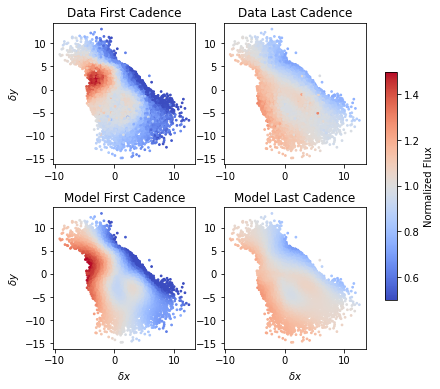

Fitting 1019 Sources (w. VA): 100%|██████████| 500/500 [01:05<00:00,  7.61it/s]


In [39]:
# make sure we use the poscorrs and 25 cadences per time bin
m67.time_corrector = "pos_corr"
m67.n_time_points = 25
m67.build_time_model(plot=True, downsample=False);
plt.show()

# fit model and get the photometry
m67.fit_model(fit_va=True)

# let's save the photometry in different vairables so we can try multiple time models
m67.ws_va_poscorr = m67.ws_va
m67.werrs_va_poscorr = m67.werrs_va

We can also use the `centroids` instead of the `pos_corrs`:

using centroids
using centroids


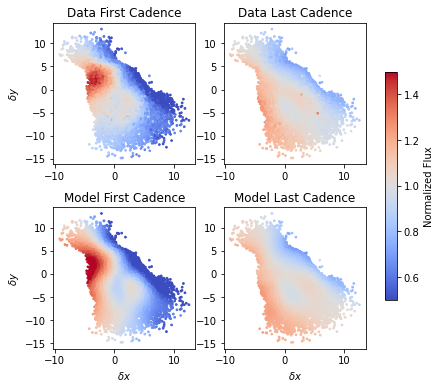

Fitting 1019 Sources (w. VA): 100%|██████████| 500/500 [00:58<00:00,  8.51it/s]


In [40]:
# make sure we use the poscorrs and 25 cadences per time bin
m67.time_corrector = "centroid"
m67.n_time_points = 25
m67.build_time_model(plot=True, downsample=False);
plt.show()

# fit model and get the photometry
m67.fit_model(fit_va=True)

# let's save the photometry in different vairables so we can try multiple time models
m67.ws_va_centroids = m67.ws_va
m67.werrs_va_centroids = m67.werrs_va

Now let's compare these light curves.

Lightcurve color code:
- black : mean-PSF model no time correction
- orange: mean-PSF model with time polynomial correction
- blue  : mean-PSF model with poscorrs correction
- green : mean-PSF model with centroid correction

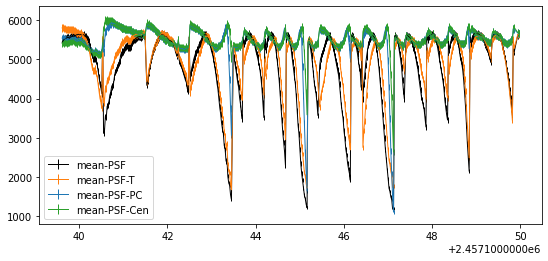

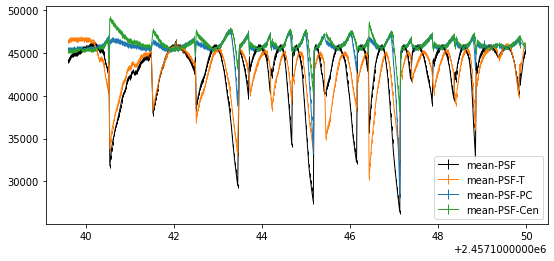

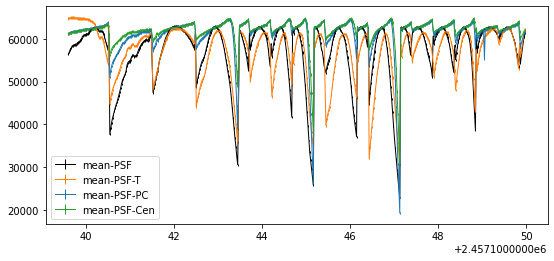

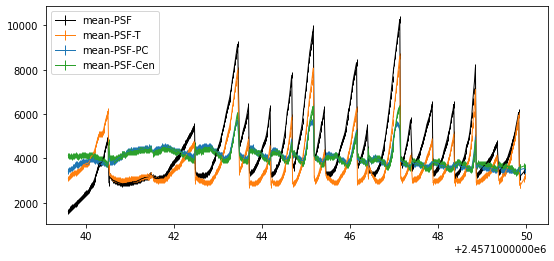

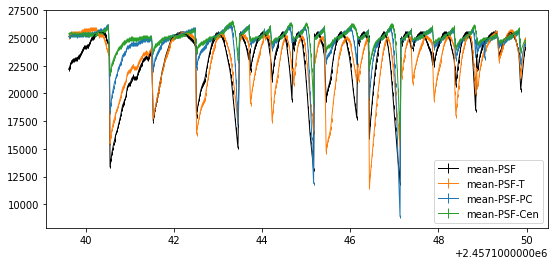

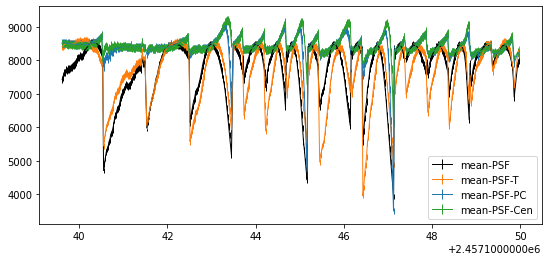

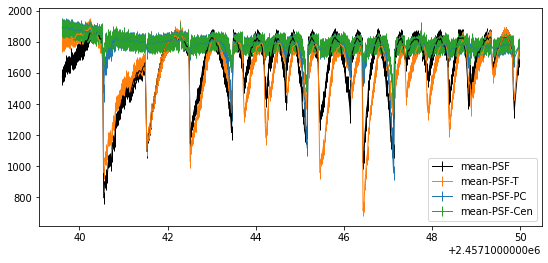

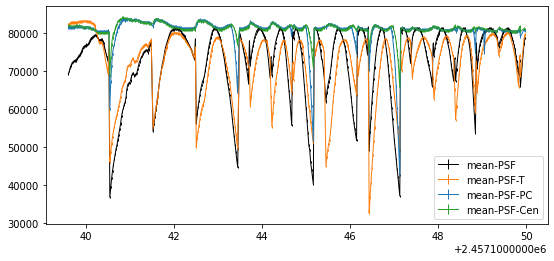

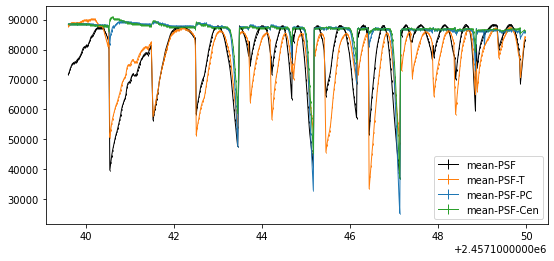

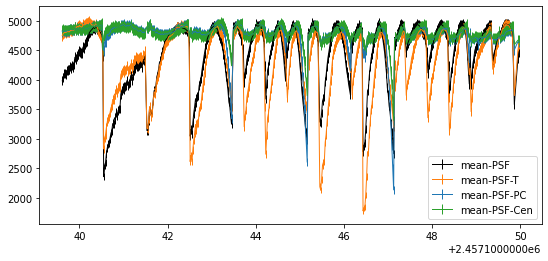

In [43]:
for k in range(0, 1000, 100):
    fig, ax = plt.subplots(1, 1, figsize=(9,4))
    ax.errorbar(m67.time, m67.ws[:, k], yerr=m67.werrs[:, k], label="mean-PSF", lw=1, color="black")
    ax.errorbar(m67.time, m67.ws_va_time[:, k], yerr=m67.werrs_va_time[:, k], label="mean-PSF-T", lw=1, color="tab:orange")
    ax.errorbar(m67.time, m67.ws_va_poscorr[:, k], yerr=m67.werrs_va_poscorr[:, k], label="mean-PSF-PC", lw=1, color="tab:blue")
    ax.errorbar(m67.time, m67.ws_va_centroids[:, k], yerr=m67.werrs_va_centroids[:, k], label="mean-PSF-Cen", lw=1, color="tab:green")
    plt.legend(loc="best")
    plt.show()

Blue ans green light curves (poscorr and centroid) look much better than no correction or time polynomial (black and orange), although we can still see the jitter and the photometry is less precise.

### Notes

Other parameters that an be modify to improve the time model are:
- m67.time_corrector        : time corrector method, options are "polynomial", "pos_corr", "centroid". Default is "pos_corr" when available, "centroid" if not.
- m67.poscorr_filter_size   : size of the Gaussian kernel used to smooth out the pos_corrs or centroids when used for the time model (see the red and blue plots above). In units of stdv. Default is 0 for no smoothing.
- m67.cartesian_knot_spacing: Type of spacing between knots when building the Cartesian design matrix that goes in the time model. Options are "linear" and "sqrt" (default).
- m67.n_r_knots             : Number of knots to fix the radius of the shape model (PRF) in Polar coordinates. See the green and purple plots above.
- m67.n_phi_knots           : Number of knots to fix the angle of the shape model (PRF) in Polar coordinates. See the green and purple plots above.
- m67.n_time_knots          : Number of knots to fix the time model in Cartesian space. This is related to `cartesian_knot_spacing`. Default is 10
- m67.n_time_points         : Number of cadences to be binned for the time model, used when calling `m67._time_bin()`. If `downsample` is `True`, the number of cadences between each downsampled point. See green points in the `pos_corr` plots above.
- m67.time_radius           : Radius at which the time model consider pixel data from the center of each source. In arcsec units.